# Определение перспективного тарифа для телеком компании

## Введение

**Цель исследования**: определение наиболее выгодного тарифа путем анализа поведения клиентов.


**Входные данные** 

Информация о пользователях `users` (*/datasets/users.csv*):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана  

Информация о звонках `calls` (*/datasets/calls.csv*):  
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Информация о сообщениях `message` (*/datasets/message.csv*): 
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Информация об интернет-сессиях `internet` (*/datasets/internet.csv*): 
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Информация о тарифах `tariffs` (*/datasets/tariffs.csv*): 
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)- 

Описание тарифов:  

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

*Справочно: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

Результаты исследования позволят определить наиболее выгодный тариф и скорректировать рекламный бюджет.

Рабочие гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общий обзор полученных данных

Импортируем библиотеку Pandas, прочтем предоставленные файлы и сохраним DataFrame в соответствующих переменных:

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

users_data = pd.read_csv('/datasets/users.csv')
calls_data = pd.read_csv('/datasets/calls.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
tariffs_info = pd.read_csv('/datasets/tariffs.csv')

Выведем и изучим общую информацию о полученных данных, проверим корректность названий столбцов, и оценим первые 5 строк полученных таблиц:

In [2]:
# Составим функцию для вывода основной информации для DataFrame:
def df_info(dataframe):
    dataframe.info()
    print()
    print(dataframe.columns)
    print()
    display(dataframe.head())

df_info(users_data)
df_info(calls_data)
df_info(messages_data)
df_info(internet_data)
df_info(tariffs_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')



,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Index(['id', 'message_date', 'user_id'], dtype='object')



,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')



,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Столбцы по содержанию соответствуют входной информации. Названия столбцов прописаны корректно: отражают содержание, формат приведен к стандарту.  
Исключение составляет столбец *Unnamed: 0* в DF `internet_data`: вероятно индексы были вынесены в отдельный столбец. Проверим это предположение и скорректируем df в случае подтверждения.

In [3]:
display(internet_data['Unnamed: 0'].value_counts())
display(internet_data['Unnamed: 0'].head(30))

2047     1
95620    1
40249    1
38200    1
60727    1
        ..
51916    1
62155    1
64202    1
58057    1
0        1
Name: Unnamed: 0, Length: 149396, dtype: int64

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: Unnamed: 0, dtype: int64

In [4]:
#Каждому индексу соответствует аналогичное значение в столбце 'Unnamed: 0'. Обновим соответствующий df, исключив этот столбец:
internet_data = internet_data.loc[:, 'id':'user_id']
display(internet_data.head())

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Вывод:**

Беглый осмотр данных показал пропуск данных в df `users_data` в столбце *churn_date*, однако исходя из описания показателя, это вероятнее всего свидетельствует о том, что на момент сбора данных тариф был действительным. Также имеет смысл изменения типа данных для столбцов, в которых прописаны даты, на *datetime*.

Теперь данные готовы к дальнейшей обработке.

## Предобработка данных

Найдем пропущенные значения в полученных df по каждому столбцу. Изменим тип данных при необходимости:

### users_data

In [5]:
def lost_data(data, column):
    print('Столбец', column)
    print(data[column].value_counts())
    print(data[column].unique())
    display(data.sort_values(column, ascending=False))
    print('Пропущенных значений:', data[column].isna().sum())
    print()
    
for columns in users_data.columns:
    lost_data(users_data, columns)

Столбец user_id
1023    1
1194    1
1181    1
1182    1
1183    1
       ..
1362    1
1363    1
1364    1
1365    1
1024    1
Name: user_id, Length: 500, dtype: int64
[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
...,...,...,...,...,...,...,...,...
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


Пропущенных значений: 0

Столбец age
53    14
42    14
63    13
71    13
64    13
73    12
21    12
40    12
39    11
47    11
29    11
26    11
37    11
41    10
36    10
58    10
45    10
70    10
52    10
51     9
27     9
48     9
50     9
28     9
30     9
24     9
20     9
19     9
56     9
23     9
68     9
66     9
65     9
69     8
62     8
60     8
44     8
55     8
25     7
43     7
67     7
35     7
74     7
32     7
31     7
46     7
75     6
54     6
59     6
18     6
33     5
34     5
38     5
22     5
72     5
49     4
57     4
61     3
Name: age, dtype: int64
[52 41 59 23 68 67 21 65 63 24 26 44 38 36 64 58 73 71 61 72 42 56 32 62
 20 51 28 66 31 37 47 40 69 48 33 39 43 46 45 55 53 34 49 25 18 70 50 19
 54 60 29 27 74 22 30 75 57 35]


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
219,1219,75,NaN,Киров,Кузьма,Некрасов,2018-01-21,smart
436,1436,75,NaN,Москва,Радим,Ерофеев,2018-04-04,ultra
478,1478,75,NaN,Грозный,Таира,Константинова,2018-07-16,smart
356,1356,75,NaN,Москва,Евгений,Гончаров,2018-04-18,ultra
177,1177,75,NaN,Новосибирск,Лолита,Аничкина,2018-06-19,smart
...,...,...,...,...,...,...,...,...
77,1077,18,NaN,Москва,Марица,Кольцова,2018-10-23,smart
473,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra
270,1270,18,NaN,Нижневартовск,Мальвина,Вешнякова,2018-07-01,ultra
268,1268,18,NaN,Москва,Трофим,Трошин,2018-05-28,smart


Пропущенных значений: 0

Столбец churn_date
2018-10-14    2
2018-12-09    2
2018-10-03    2
2018-12-21    2
2018-12-03    2
2018-12-30    1
2018-11-22    1
2018-09-26    1
2018-10-25    1
2018-12-23    1
2018-11-07    1
2018-11-26    1
2018-09-27    1
2018-11-13    1
2018-08-17    1
2018-12-25    1
2018-08-31    1
2018-11-21    1
2018-12-11    1
2018-10-27    1
2018-12-24    1
2018-12-18    1
2018-12-14    1
2018-09-02    1
2018-12-16    1
2018-11-16    1
2018-12-20    1
2018-10-04    1
2018-11-30    1
2018-10-28    1
2018-10-05    1
2018-12-26    1
2018-11-27    1
Name: churn_date, dtype: int64
[nan '2018-10-05' '2018-12-18' '2018-11-21' '2018-10-03' '2018-10-14'
 '2018-12-09' '2018-12-11' '2018-12-26' '2018-08-31' '2018-12-03'
 '2018-12-23' '2018-11-07' '2018-12-16' '2018-12-20' '2018-11-30'
 '2018-12-21' '2018-08-17' '2018-09-02' '2018-10-04' '2018-11-13'
 '2018-11-22' '2018-10-28' '2018-11-26' '2018-11-27' '2018-11-16'
 '2018-10-27' '2018-12-30' '2018-09-27' '2018-12-25' '2018-12-1

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
399,1399,31,2018-12-25,Уфа,Алиса,Абрашина,2018-11-06,ultra
438,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
...,...,...,...,...,...,...,...,...
494,1494,62,NaN,Омск,Ренат,Андропов,2018-08-17,smart
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart


Пропущенных значений: 462

Столбец city
Москва             99
Санкт-Петербург    39
Новосибирск        16
Казань             14
Омск               14
                   ..
Подольск            1
Химки               1
Архангельск         1
Иваново             1
Нижневартовск       1
Name: city, Length: 76, dtype: int64
['Краснодар' 'Москва' 'Стерлитамак' 'Новокузнецк' 'Набережные Челны'
 'Ульяновск' 'Челябинск' 'Пермь' 'Тюмень' 'Самара' 'Санкт-Петербург'
 'Иваново' 'Чебоксары' 'Омск' 'Уфа' 'Томск' 'Чита' 'Мурманск'
 'Петрозаводск' 'Тверь' 'Екатеринбург' 'Махачкала' 'Вологда' 'Череповец'
 'Ярославль' 'Сочи' 'Хабаровск' 'Ставрополь' 'Рязань' 'Улан-Удэ' 'Тула'
 'Саратов' 'Ростов-на-Дону' 'Казань' 'Иркутск' 'Курск' 'Калуга' 'Якутск'
 'Астрахань' 'Химки' 'Владикавказ' 'Волгоград' 'Саранск' 'Ижевск'
 'Новосибирск' 'Брянск' 'Тольятти' 'Нижний Тагил' 'Орёл' 'Белгород'
 'Воронеж' 'Волжский' 'Курган' 'Барнаул' 'Красноярск' 'Архангельск'
 'Липецк' 'Кемерово' 'Киров' 'Сургут' 'Пенза' 'Магнитогорск'


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
472,1472,53,NaN,Ярославль,Наида,Боброва,2018-01-18,smart
39,1039,40,NaN,Ярославль,Агнесса,Андреенко,2018-06-21,ultra
198,1198,26,NaN,Ярославль,Эдуард,Швецов,2018-08-15,smart
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
147,1147,63,NaN,Якутск,Владимир,Синицын,2018-07-09,smart
...,...,...,...,...,...,...,...,...
66,1066,47,NaN,Астрахань,Исак,Малахов,2018-06-24,smart
423,1423,50,NaN,Астрахань,Леон,Силин,2018-01-23,smart
280,1280,53,NaN,Астрахань,Артемий,Худяков,2018-07-18,smart
253,1253,29,NaN,Астрахань,Алла,Масленникова,2018-08-06,ultra


Пропущенных значений: 0

Столбец first_name
Радим      6
Пётр       5
Леонид     5
Матвей     4
Алиса      4
          ..
Дебора     1
Глеб       1
Галина     1
Рената     1
Зинаида    1
Name: first_name, Length: 246, dtype: int64
['Рафаил' 'Иван' 'Евгений' 'Белла' 'Татьяна' 'Афанасий' 'Леонид' 'Юна'
 'Рустэм' 'Василиса' 'Эдуард' 'Веселина' 'Варлам' 'Борис' 'Яков' 'Рузана'
 'Марица' 'Мария' 'Матвей' 'Игнатий' 'Тала' 'Святослав' 'Людмила' 'Иулиан'
 'Владислав' 'Рустем' 'Алексей' 'Мариетта' 'Лаврентий' 'Инна' 'Лия'
 'Розалия' 'Анжелика' 'Изольда' 'Агнесса' 'Юрий' 'Михаил' 'Константин'
 'Марианна' 'Иннокентий' 'Джемма' 'Екатерина' 'Милица' 'Лола' 'Габриель'
 'Кристина' 'Павел' 'Ренальд' 'Луиза' 'Радислав' 'Динара' 'Лукий' 'Глеб'
 'Тамара' 'Александр' 'Таира' 'Роза' 'Исак' 'Юзефа' 'Ким' 'Гордей' 'Эльза'
 'Гектор' 'Андрей' 'Рафаэль' 'Фёдор' 'Харитон' 'Еремей' 'Всеволод' 'Софья'
 'Авксентий' 'Виолетта' 'Ириней' 'Гелена' 'Ксения' 'Вера' 'Вениамин'
 'Вероника' 'Даниэла' 'Алла' 'Элеонора' 'Аюна

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
207,1207,57,NaN,Балашиха,Яна,Зеленина,2018-08-12,smart
126,1126,71,NaN,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra
267,1267,63,NaN,Екатеринбург,Яна,Седова,2018-08-05,smart
14,1014,64,NaN,Чебоксары,Яков,Акинфьев,2018-05-15,smart
60,1060,46,NaN,Калуга,Яков,Рудаков,2018-11-24,ultra
...,...,...,...,...,...,...,...,...
235,1235,26,NaN,Москва,Агафья,Басова,2018-10-06,smart
199,1199,27,NaN,Чебоксары,Агата,Демьянова,2018-09-10,smart
336,1336,27,NaN,Уфа,Авксентий,Алексеичев,2018-12-31,ultra
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra


Пропущенных значений: 0

Столбец last_name
Андреенко     5
Березина      3
Абашкина      3
Соловьев      3
Аничкина      3
             ..
Селиванова    1
Авдушева      1
Тимофеев      1
Авдюков       1
Третьякова    1
Name: last_name, Length: 419, dtype: int64
['Верещагин' 'Ежов' 'Абрамович' 'Белякова' 'Авдеенко' 'Горлов' 'Ермолаев'
 'Березина' 'Пономарёв' 'Блинова' 'Кононов' 'Алёшко' 'Соловьев'
 'Андреенко' 'Акинфьев' 'Алюшина' 'Сазонова' 'Аленникова' 'Золотов'
 'Круглов' 'Костина' 'Тихонов' 'Трофимова' 'Мельникова' 'Антипов' 'Акинин'
 'Бородин' 'Авдеев' 'Евсеев' 'Селезнев' 'Русанова' 'Тимофеев' 'Игнатьева'
 'Бабушкина' 'Бондарев' 'Аракина' 'Андропова' 'Архипова' 'Денисова'
 'Одинцов' 'Кравцов' 'Добрынин' 'Родионова' 'Рябов' 'Карасева'
 'Александрова' 'Меркулова' 'Мясникова' 'Ларин' 'Аничкина' 'Сомова'
 'Панов' 'Фёдоров' 'Платонова' 'Артемьев' 'Дьячкова' 'Глушков' 'Свиридов'
 'Рудаков' 'Ситникова' 'Коршунов' 'Климова' 'Алфеева' 'Игнатова' 'Малахов'
 'Абашкина' 'Демьянов' 'Кочетов' 'С

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
419,1419,19,NaN,Новороссийск,Эльмира,Яшина,2018-07-19,smart
152,1152,44,NaN,Мурманск,Марина,Щербакова,2018-02-05,ultra
116,1116,65,NaN,Петрозаводск,Альберта,Шевцова,2018-04-17,smart
466,1466,37,NaN,Новосибирск,Рубен,Шевцов,2018-02-28,ultra
198,1198,26,NaN,Ярославль,Эдуард,Швецов,2018-08-15,smart
...,...,...,...,...,...,...,...,...
459,1459,31,NaN,Магнитогорск,Леон,Ёрохов,2018-10-10,smart
239,1239,68,NaN,Самара,Даниил,Ёрохов,2018-06-12,smart
345,1345,31,NaN,Москва,Галина,Ёркина,2018-06-01,smart
465,1465,41,NaN,Омск,Пётр,Ёркин,2018-04-14,smart


Пропущенных значений: 0

Столбец reg_date
2018-05-28    8
2018-10-05    5
2018-04-03    5
2018-11-16    5
2018-01-04    5
             ..
2018-12-06    1
2018-02-03    1
2018-08-18    1
2018-08-07    1
2018-12-30    1
Name: reg_date, Length: 270, dtype: int64
['2018-05-25' '2018-11-01' '2018-06-17' '2018-08-17' '2018-05-14'
 '2018-01-25' '2018-02-26' '2018-04-19' '2018-12-19' '2018-03-22'
 '2018-08-05' '2018-03-19' '2018-03-28' '2018-11-14' '2018-05-15'
 '2018-04-30' '2018-11-21' '2018-05-22' '2018-04-01' '2018-05-16'
 '2018-10-22' '2018-04-26' '2018-12-01' '2018-10-31' '2018-03-15'
 '2018-10-06' '2018-04-10' '2018-10-02' '2018-09-15' '2018-05-23'
 '2018-11-02' '2018-01-04' '2018-07-15' '2018-08-26' '2018-04-03'
 '2018-07-14' '2018-10-13' '2018-10-07' '2018-06-21' '2018-06-08'
 '2018-11-29' '2018-11-25' '2018-07-08' '2018-05-09' '2018-01-30'
 '2018-08-20' '2018-10-29' '2018-08-19' '2018-03-10' '2018-06-16'
 '2018-05-28' '2018-07-27' '2018-09-30' '2018-03-20' '2018-01-02'
 '2018-04-13' 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
336,1336,27,NaN,Уфа,Авксентий,Алексеичев,2018-12-31,ultra
258,1258,52,NaN,Санкт-Петербург,Валерий,Беляев,2018-12-31,smart
140,1140,22,NaN,Киров,Леонид,Ахматулин,2018-12-31,smart
74,1074,68,NaN,Якутск,Андрей,Кравцов,2018-12-30,smart
445,1445,40,NaN,Москва,Рауль,Иванов,2018-12-29,smart
...,...,...,...,...,...,...,...,...
254,1254,75,2018-08-17,Москва,Александра,Сухарева,2018-01-04,ultra
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
55,1055,39,NaN,Казань,Луиза,Березина,2018-01-02,smart
453,1453,50,NaN,Москва,Кузьма,Акуленко,2018-01-01,ultra


Пропущенных значений: 0

Столбец tariff
smart    351
ultra    149
Name: tariff, dtype: int64
['ultra' 'smart']


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
156,1156,63,NaN,Набережные Челны,Валерий,Галкин,2018-11-12,ultra
382,1382,42,NaN,Самара,Оксана,Нестерова,2018-03-26,ultra
381,1381,64,NaN,Москва,Тамара,Серебрякова,2018-01-13,ultra
380,1380,45,NaN,Ростов-на-Дону,Доминика,Карасева,2018-05-07,ultra
...,...,...,...,...,...,...,...,...
187,1187,60,NaN,Рязань,Виталий,Овчинников,2018-08-22,smart
186,1186,21,NaN,Самара,Рэм,Абакумов,2018-02-02,smart
184,1184,21,NaN,Барнаул,Снежана,Тарасова,2018-09-03,smart
183,1183,20,NaN,Владивосток,Снежана,Озерова,2018-07-12,smart


Пропущенных значений: 0



Пропущенные значения наблюдаются только по столбцу *churn_date*, однако наличие пропусков в нем обусловлено входной информацией. Поскольку на дальнейшее исследование пропуски не должны повлиять, оставим данные в столбце в текщем виде.
Что мы можем сделать с df, это поменять тип данных в столбцах *churn_date*, *reg_date* на datetime:

In [6]:
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format ='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format ='%Y-%m-%d')
print(users_data.dtypes)

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object


### calls_data

In [7]:
for columns in calls_data.columns:
    lost_data(calls_data, columns)

Столбец id
1248_706     1
1078_891     1
1261_131     1
1243_391     1
1402_508     1
            ..
1453_1174    1
1021_622     1
1168_1393    1
1014_209     1
1197_106     1
Name: id, Length: 202607, dtype: int64
['1000_0' '1000_1' '1000_2' ... '1499_217' '1499_218' '1499_219']


,id,call_date,duration,user_id
202486,1499_99,2018-11-04,0.00,1499
202485,1499_98,2018-10-29,0.00,1499
202484,1499_97,2018-12-22,0.07,1499
202483,1499_96,2018-10-23,0.00,1499
202482,1499_95,2018-12-22,9.26,1499
...,...,...,...,...
101,1000_101,2018-09-29,12.61,1000
100,1000_100,2018-06-18,10.77,1000
10,1000_10,2018-08-22,5.03,1000
1,1000_1,2018-08-17,0.00,1000


Пропущенных значений: 0

Столбец call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64
['2018-07-25' '2018-08-17' '2018-06-11' '2018-09-21' '2018-12-15'
 '2018-11-02' '2018-10-18' '2018-08-22' '2018-09-15' '2018-08-15'
 '2018-05-28' '2018-07-05' '2018-09-29' '2018-12-11' '2018-07-27'
 '2018-08-11' '2018-08-02' '2018-06-15' '2018-12-04' '2018-08-20'
 '2018-09-25' '2018-07-21' '2018-08-27' '2018-08-25' '2018-12-12'
 '2018-07-19' '2018-11-14' '2018-12-26' '2018-12-02' '2018-10-08'
 '2018-09-23' '2018-10-09' '2018-05-25' '2018-06-13' '2018-10-25'
 '2018-12-29' '2018-07-12' '2018-11-20' '2018-06-05' '2018-10-13'
 '2018-06-26' '2018-07-14' '2018-07-20' '2018-12-01' '2018-06-17'
 '2018-10-24' '2018-11-26' '2018-09-19' '2018-05-30' '2018-12-21'
 '2018-12-23' '2018-07-03' '2018-10-04' '2018

,id,call_date,duration,user_id
60429,1152_126,2018-12-31,0.00,1152
141585,1360_28,2018-12-31,11.21,1360
152387,1380_22,2018-12-31,0.12,1380
99199,1251_561,2018-12-31,2.04,1251
141690,1360_133,2018-12-31,11.63,1360
...,...,...,...,...
180968,1453_160,2018-01-01,0.00,1453
76907,1193_169,2018-01-01,13.29,1193
181239,1453_431,2018-01-01,19.92,1453
181903,1453_1095,2018-01-01,5.63,1453


Пропущенных значений: 0

Столбец duration
0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64
[ 0.    2.85 13.8  ... 24.36 24.5  26.9 ]


,id,call_date,duration,user_id
95088,1241_44,2018-09-06,38.00,1241
178737,1446_22,2018-11-07,37.35,1446
5865,1017_61,2018-11-13,36.47,1017
39777,1099_150,2018-08-14,36.12,1099
60889,1153_135,2018-11-16,35.95,1153
...,...,...,...,...
45132,1113_548,2018-12-16,0.00,1113
144950,1365_82,2018-11-25,0.00,1365
144952,1365_84,2018-12-20,0.00,1365
45127,1113_543,2018-11-21,0.00,1113


Пропущенных значений: 0

Столбец user_id
1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64
[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1092 1093 1094 1095 1096 1097 1098
 1099 1100 1101 1102 1103 1104 1105 1107 1108 1109 1110 1111 1112 1113
 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126 1127
 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140 1141 1142
 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154 1155

,id,call_date,duration,user_id
202606,1499_219,2018-12-14,19.62,1499
202455,1499_68,2018-12-10,4.08,1499
202466,1499_79,2018-10-14,7.72,1499
202465,1499_78,2018-11-12,16.28,1499
202464,1499_77,2018-10-21,0.00,1499
...,...,...,...,...
248,1000_248,2018-10-08,9.99,1000
249,1000_249,2018-07-10,5.08,1000
250,1000_250,2018-06-24,0.00,1000
251,1000_251,2018-06-26,0.00,1000


Пропущенных значений: 0



В рассматриваемой таблице отсутствуют пропущенные значения. Однако в столбце *duration* присутствуют "нулевые" звонки - вероятно являбщиеся пропущенными. Их число сотавляет около 19,6%. Поскольку для целей исследования данные наблюдения не представляют интереса (нам требуются именно оценить эффективность тарифов, зависящих от продолжительности звонка), сохранение данных приведет к искажению показателя количества звонков за месяц. 

Исключим "нулевые" звонки, заодно изменим тип данных в столбце *call_date* на datetime. Кроме этого, поскольку согласно входным данным оператор всегда округляет вверх значения минут, округлим значения столбца *'duration'* до целых значений и изменим тип данных на *int*:

In [8]:
calls_data = calls_data.query('duration != 0')
# Округляем значения вверх
calls_data['duration'] = calls_data['duration'].apply(np.ceil)

calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format ='%Y-%m-%d')
calls_data['duration'] = calls_data['duration'].astype('int')
print(calls_data.dtypes)

id                   object
call_date    datetime64[ns]
duration              int64
user_id               int64
dtype: object


### messages_data

In [9]:
for columns in messages_data.columns:
    lost_data(messages_data, columns)

Столбец id
1285_454    1
1035_444    1
1105_171    1
1124_231    1
1130_67     1
           ..
1039_549    1
1268_315    1
1356_395    1
1126_6      1
1197_106    1
Name: id, Length: 123036, dtype: int64
['1000_0' '1000_1' '1000_2' ... '1499_181' '1499_182' '1499_183']


,id,message_date,user_id
122951,1499_99,2018-12-24,1499
122950,1499_98,2018-12-25,1499
122949,1499_97,2018-10-01,1499
122948,1499_96,2018-12-23,1499
122947,1499_95,2018-11-15,1499
...,...,...,...
101,1000_101,2018-07-22,1000
100,1000_100,2018-08-20,1000
10,1000_10,2018-05-30,1000
1,1000_1,2018-10-08,1000


Пропущенных значений: 0

Столбец message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-26    699
             ... 
2018-01-11     12
2018-01-05     10
2018-01-02     10
2018-01-04     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64
['2018-06-27' '2018-10-08' '2018-08-04' '2018-06-16' '2018-12-05'
 '2018-06-20' '2018-11-19' '2018-10-29' '2018-06-25' '2018-12-18'
 '2018-05-30' '2018-07-06' '2018-08-20' '2018-10-30' '2018-09-14'
 '2018-08-28' '2018-06-29' '2018-07-07' '2018-05-29' '2018-05-28'
 '2018-08-15' '2018-07-29' '2018-12-07' '2018-12-25' '2018-10-31'
 '2018-07-30' '2018-11-05' '2018-12-15' '2018-12-04' '2018-06-30'
 '2018-12-22' '2018-10-02' '2018-08-29' '2018-09-09' '2018-07-19'
 '2018-09-04' '2018-07-15' '2018-10-25' '2018-12-08' '2018-06-01'
 '2018-06-12' '2018-12-21' '2018-10-07' '2018-08-30' '2018-06-04'
 '2018-10-01' '2018-06-22' '2018-10-12' '2018-10-15' '2018-10-24'
 '2018-09-20' '2018-08-22' '2018-09-17' '2018-08-2

,id,message_date,user_id
106601,1431_343,2018-12-31,1431
53386,1236_42,2018-12-31,1236
120508,1488_39,2018-12-31,1488
72225,1304_21,2018-12-31,1304
46925,1205_30,2018-12-31,1205
...,...,...,...
112041,1453_66,2018-01-02,1453
44492,1193_248,2018-01-02,1193
35665,1155_54,2018-01-02,1155
36149,1155_538,2018-01-02,1155


Пропущенных значений: 0

Столбец user_id
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64
[1000 1002 1003 1004 1005 1007 1008 1009 1011 1012 1013 1014 1015 1016
 1018 1019 1020 1021 1022 1023 1025 1026 1027 1028 1029 1030 1031 1032
 1033 1034 1035 1036 1037 1038 1039 1041 1042 1043 1044 1045 1046 1047
 1048 1050 1051 1052 1054 1055 1056 1057 1058 1059 1060 1061 1062 1064
 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1079
 1080 1081 1082 1083 1084 1086 1087 1088 1089 1090 1091 1092 1093 1094
 1096 1097 1098 1099 1100 1102 1103 1104 1105 1106 1108 1109 1110 1111
 1112 1113 1115 1119 1121 1122 1123 1124 1125 1126 1127 1130 1131 1133
 1134 1135 1136 1137 1138 1139 1140 1141 1142 1144 1145 1146 1147 1148
 1149 1150 1151 1154 1155 1156 1158 1159 1160 1161 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1176 1178 1180 1181 1182

,id,message_date,user_id
123035,1499_183,2018-11-16,1499
122909,1499_57,2018-12-17,1499
122918,1499_66,2018-10-20,1499
122917,1499_65,2018-12-25,1499
122916,1499_64,2018-12-24,1499
...,...,...,...
336,1000_336,2018-12-06,1000
337,1000_337,2018-07-14,1000
338,1000_338,2018-12-29,1000
339,1000_339,2018-07-25,1000


Пропущенных значений: 0



Пропущенных значений в данной таблице нет. Изменим тип данных в столбце *message_date* на datetime:

In [10]:
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format ='%Y-%m-%d')
print(messages_data.dtypes)

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object


### internet_data

In [11]:
for columns in internet_data.columns:
    lost_data(internet_data, columns)

Столбец id
1268_343    1
1317_145    1
1419_178    1
1172_107    1
1044_291    1
           ..
1429_70     1
1055_144    1
1209_91     1
1130_321    1
1197_106    1
Name: id, Length: 149396, dtype: int64
['1000_0' '1000_1' '1000_2' ... '1499_154' '1499_155' '1499_156']


,id,mb_used,session_date,user_id
149338,1499_99,178.46,2018-12-14,1499
149337,1499_98,1138.32,2018-09-29,1499
149336,1499_97,558.11,2018-12-05,1499
149335,1499_96,257.39,2018-10-04,1499
149334,1499_95,271.53,2018-10-05,1499
...,...,...,...,...
101,1000_101,891.71,2018-06-25,1000
100,1000_100,664.51,2018-11-30,1000
10,1000_10,385.14,2018-09-27,1000
1,1000_1,1052.81,2018-09-07,1000


Пропущенных значений: 0

Столбец mb_used
0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64
[ 112.95 1052.81 1197.26 ...  460.75  247.59   23.72]


,id,mb_used,session_date,user_id
137493,1461_9,1724.83,2018-11-28,1461
119156,1402_191,1702.75,2018-10-26,1402
7063,1024_118,1651.55,2018-11-15,1024
103480,1348_138,1651.25,2018-10-31,1348
140299,1471_182,1623.92,2018-07-29,1471
...,...,...,...,...
118555,1400_266,0.00,2018-10-14,1400
112336,1380_465,0.00,2018-08-06,1380
118557,1400_268,0.00,2018-12-27,1400
15836,1055_294,0.00,2018-09-16,1055


Пропущенных значений: 0

Столбец session_date
2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-01       3
2018-01-02       3
Name: session_date, Length: 365, dtype: int64
['2018-11-25' '2018-09-07' '2018-06-25' '2018-08-22' '2018-09-24'
 '2018-10-02' '2018-07-11' '2018-10-08' '2018-09-03' '2018-09-27'
 '2018-08-28' '2018-06-20' '2018-08-09' '2018-08-11' '2018-07-21'
 '2018-06-09' '2018-06-03' '2018-11-01' '2018-11-28' '2018-08-20'
 '2018-12-06' '2018-07-02' '2018-10-19' '2018-10-30' '2018-06-17'
 '2018-11-06' '2018-09-14' '2018-11-15' '2018-08-26' '2018-10-15'
 '2018-11-27' '2018-10-17' '2018-10-07' '2018-08-05' '2018-07-06'
 '2018-10-03' '2018-11-02' '2018-06-30' '2018-11-17' '2018-06-06'
 '2018-11-20' '2018-05-31' '2018-10-29' '2018-12-10' '2018-07-04'
 '2018-12-28' '2018-05-28' '2018-09-15' '2018-09-09' '2018-09-17'
 '2018-09-01' '2018-11-03' '2018-11-04'

,id,mb_used,session_date,user_id
126447,1424_308,812.61,2018-12-31,1424
25657,1088_292,86.13,2018-12-31,1088
105669,1357_96,511.71,2018-12-31,1357
105667,1357_94,573.59,2018-12-31,1357
64885,1220_84,280.84,2018-12-31,1220
...,...,...,...,...
15889,1055_347,326.80,2018-01-02,1055
45314,1155_501,0.00,2018-01-02,1155
135277,1453_498,209.31,2018-01-01,1453
135081,1453_302,794.96,2018-01-01,1453


Пропущенных значений: 0

Столбец user_id
1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64
[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140
 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154
 1155

,id,mb_used,session_date,user_id
149395,1499_156,544.37,2018-10-26,1499
149288,1499_49,97.76,2018-11-06,1499
149295,1499_56,766.77,2018-10-28,1499
149294,1499_55,0.00,2018-11-18,1499
149293,1499_54,277.51,2018-10-31,1499
...,...,...,...,...
139,1000_139,924.69,2018-11-14,1000
138,1000_138,555.33,2018-06-27,1000
137,1000_137,463.39,2018-06-13,1000
136,1000_136,986.80,2018-07-13,1000


Пропущенных значений: 0



Пропущенных данных в таблице также нет. Однако по аналогии со звонками, имеются "нулевые" значения по столбцу *mb_used*, возникновение которых может быть связано с провальными попытками подключения к Интернету. Их количество составляет более 13% от общего числа интернет-сессий. Исключение этих значений не должно повлиять на чистоту исследования, поскольку нам необходимо выявить израсходованный интернет траффик, а число интернет-сессий в задачу не включается. Однако их исключение позволит ускорить процесс обработки информации. 

Исключим "нулевые" интернет-сессии, заодно изменим тип данных в столбце *session_date* на datetime. Кроме этого, поскольку согласно входным данным оператор всегда округляет вверх значения мегабайтов, округлим значения столбца *'mb_used'* до целых значений и изменим тип данных на *int*:

In [12]:
internet_data = internet_data.query('mb_used != 0')

# Округляем до целых вверх
internet_data['mb_used'] = internet_data['mb_used'].apply(np.ceil)

internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format ='%Y-%m-%d')
internet_data['mb_used'] = internet_data['mb_used'].astype('int')
print(internet_data.dtypes)

id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object


### tariffs_info

In [13]:
display(tariffs_info)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице нет пропущенных значений, типы данных корректны. 

Проверим также дубликаты в таблицах и исключим их в случае наличия:

In [14]:
def duplicates_df_info(data):
    print('Количество дубликатов:', data.duplicated().sum())

print('users_data')
duplicates_df_info(users_data)
print('calls_data')
duplicates_df_info(calls_data)
print('messages_data')
duplicates_df_info(messages_data)
print('internet_data')
duplicates_df_info(internet_data)

users_data
Количество дубликатов: 0
calls_data
Количество дубликатов: 0
messages_data
Количество дубликатов: 0
internet_data
Количество дубликатов: 0


## Рассчет вспомогательных показателей и формирование сводной таблицы

### Количество совершенных звонков и израсходованных минут разговора по месяцам

Для подсчета количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя, на базе таблицы `calls_data` создадим новый df, используя метод .pivot_table(), предварительно создав столбец *'month'*, в котором будет отображаться месяц осуществленного клиентом звонка:

In [15]:
# Создаем столбец 'month':
calls_data['month'] = calls_data['call_date'].dt.month
# Проверим результат:
display(calls_data.head())

# Создадим сводную таблицу для расчета количества звонков по месяцам:
calls_data_pivot_by_number = calls_data.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='count')
#display(calls_data_pivot_by_number)

# Создадим сводную таблицу для расчета количества звонков по месяцам:
calls_data_pivot_by_duration = calls_data.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
#display(calls_data_pivot_by_duration)

# Объединим полученные сводные таблицы в одну и переименуем название столбцов:
calls_data_pivot = calls_data_pivot_by_number.merge(calls_data_pivot_by_duration, on=['user_id', 'month'], how='outer').reset_index()
calls_data_pivot.set_axis(['user_id', 'month', 'total_calls', 'total_duration'], axis='columns', inplace=True)
display(calls_data_pivot.head())

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


,user_id,month,total_calls,total_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466


### Количество отправленных сообщений по месяцам

По аналогии с прошлым показателем составим сводную таблицу для поиска количества отправленных сообщений на базе таблицы `messages_data`:

In [16]:
# Создаем столбец 'month':
messages_data['month'] = messages_data['message_date'].dt.month
# Проверим результат:
display(messages_data.head())

# Создадим сводную таблицу для расчета количества сообщений по месяцам:
messages_data_pivot = messages_data.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()
messages_data_pivot.set_axis(['user_id', 'month', 'total_messages'], axis='columns', inplace=True)
display(messages_data_pivot.head())

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


,user_id,month,total_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика по месяцам

По аналогии с прошлым показателем составим сводную таблицу для поиска объема израсходованного интернет-трафика на базе таблицы `internet_data`:

In [17]:
# Создаем столбец 'month':
internet_data['month'] = internet_data['session_date'].dt.month
# Проверим результат:
display(internet_data.head())

# Создадим сводную таблицу для расчета объема израсходованного интернет-трафика по месяцам:
internet_data_pivot = internet_data.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet_data_pivot.set_axis(['user_id', 'month', 'total_mb_used'], axis='columns', inplace=True)
display(internet_data_pivot.head())

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


,user_id,month,total_mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


### Формирование сводной таблицы и расчет ежемесячной выручки

Для построения сводной таблицы с помесячными показателями каждого пользователя, объединим полученные сводные таблицы `calls_data_pivot`, `messages_data_pivot`, `internet_data_pivot` и данные из таблицы `users_data` в новый df `final_users_data`:

In [18]:
final_users_data = calls_data_pivot.merge(messages_data_pivot, on=['user_id', 'month'], how='outer')
final_users_data = final_users_data.merge(internet_data_pivot, on=['user_id', 'month'], how='outer')
final_users_data = final_users_data.merge(users_data, on='user_id', how='outer')

display(final_users_data.head())

,user_id,month,total_calls,total_duration,total_messages,total_mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,17.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,28.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,41.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,42.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,46.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Добавим столбец, отражающий среднюю длительность одного звонка:

In [19]:
# Добавляем столбец 'mean_duration'
final_users_data['mean_duration'] = final_users_data['total_duration'] / final_users_data['total_calls']

Проверим полученную таблицу на наличие пропущенных значений в полученных показателях:

In [20]:
# Найдем количество пропусков в разрезе столбцов:
final_users_data.isna().sum()

user_id              0
month                2
total_calls         48
total_duration      48
total_messages     499
total_mb_used       15
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
mean_duration       48
dtype: int64

Пропуски в столбцах *'total_calls'*, *'total_duration'*, *'total_messages'*, *'total_mb_used'* означают, что в данном месяце клиент не пользовался соответствующими услугами. Пропуски в столбце *'churn_date'* уже оговаривались ранее - на  момент сбора данных клиент пользовался услугами.  

Подозрительно выглядят 2 пропуска по столбцу *'month'* - их наличие может означать, что клиент не пользовался услугами опреатора в обозначенный период вообще. Если это подтвердится, мы можем исключить его из итоговой таблицы:

In [21]:
# Проверим строки с отсутствующим месяцем:
display(final_users_data.query('month == "NaN"'))

# Похже на истину: дата регистрации и прекращения пользования тарифом в лучшем случае составляет чуть более недели.
# На всякий случай удостоверимся, что по указанным клиентам нет никаких данных по рассматриваемым показателям.
display(final_users_data.query('user_id == 1128 or user_id == 1371'))

# Предположение подтвердилось. Исключим данныхклиентов из общей таблицы:
final_users_data = final_users_data.query('month != "NaN"')
final_users_data.isna().sum()

,user_id,month,total_calls,total_duration,total_messages,total_mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,mean_duration
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN
3215,1371,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN


,user_id,month,total_calls,total_duration,total_messages,total_mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,mean_duration
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN
3215,1371,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN


user_id              0
month                0
total_calls         46
total_duration      46
total_messages     497
total_mb_used       13
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
mean_duration       46
dtype: int64

Заменим пропуски в столбцах *'total_calls'*, *'total_duration'*, *'total_messages'*, *'total_mb_used'* на нулевые значения:

In [22]:
def nan_to_0(data, column):
    data[column] = data[column].fillna(0)
    return data

nan_to_0(final_users_data, 'total_calls')
nan_to_0(final_users_data, 'total_duration')
nan_to_0(final_users_data, 'total_messages')
nan_to_0(final_users_data, 'total_mb_used')
nan_to_0(final_users_data, 'mean_duration')

final_users_data.isna().sum()

user_id              0
month                0
total_calls          0
total_duration       0
total_messages       0
total_mb_used        0
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
mean_duration        0
dtype: int64

Дополним таблицу `final_users_data` столбами для расчета выручки *'total_revenue'*, где будет отражена помесячная выручка с каждого пользователя за месяц, используя данные из таблицы `tariffs_info`:

In [23]:
# Функция для ежемесячной абонентской платой в рублях:
def monthly_fee(row):
    tariff = row['tariff']
    if tariff == 'ultra':
        return tariffs_info.loc[1, 'rub_monthly_fee']
    return tariffs_info.loc[0, 'rub_monthly_fee']

# Функция для выручки от звонков сверх лимита:
def calls_revenue(row):
    tariff = row['tariff']
    total_duration = row['total_duration']
    if tariff == 'ultra':
        if total_duration > tariffs_info.loc[1, 'minutes_included']:
            return (total_duration - tariffs_info.loc[1, 'minutes_included']) * tariffs_info.loc[1, 'rub_per_minute']
        return 0
    else:
        if total_duration > tariffs_info.loc[0, 'minutes_included']:
            return (total_duration - tariffs_info.loc[0, 'minutes_included']) * tariffs_info.loc[0, 'rub_per_minute']
        return 0

# Функция для выручки от сообщений сверх лимита:
def messages_revenue(row):
    tariff = row['tariff']
    total_messages = row['total_messages']
    if tariff == 'ultra':
        if total_messages > tariffs_info.loc[1, 'messages_included']:
            return (total_messages - tariffs_info.loc[1, 'messages_included']) * tariffs_info.loc[1, 'rub_per_message']
        return 0
    else:
        if total_messages > tariffs_info.loc[0, 'minutes_included']:
            return (total_messages - tariffs_info.loc[0, 'messages_included']) * tariffs_info.loc[0, 'rub_per_message']
        return 0    

# Функция для выручки от израсходованного интернет-трафика сверх лимита:
def internet_revenue(row):
    tariff = row['tariff']
    total_mb_used = row['total_mb_used']
    if tariff == 'ultra':
        if total_mb_used > tariffs_info.loc[1, 'mb_per_month_included']:
            return math.ceil((total_mb_used - tariffs_info.loc[1, 'mb_per_month_included']) / 1024) * tariffs_info.loc[1, 'rub_per_gb']
        return 0
    else:
        if total_mb_used > tariffs_info.loc[0, 'mb_per_month_included']:
            return math.ceil((total_mb_used - tariffs_info.loc[0, 'mb_per_month_included']) / 1024) * tariffs_info.loc[0, 'rub_per_gb']
        return 0        

# Добавим столбцы в общую таблицу:
final_users_data['monthly_fee'] = final_users_data.apply(monthly_fee, axis=1)  
final_users_data['calls_revenue'] = final_users_data.apply(calls_revenue, axis=1)
final_users_data['messages_revenue'] = final_users_data.apply(messages_revenue, axis=1)
final_users_data['internet_revenue'] = final_users_data.apply(internet_revenue, axis=1)
final_users_data['total_revenue'] = (final_users_data['monthly_fee'] + final_users_data['calls_revenue'] + 
                                     final_users_data['messages_revenue'] + final_users_data['internet_revenue'])
display(final_users_data.head())

,user_id,month,total_calls,total_duration,total_messages,total_mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,mean_duration,monthly_fee,calls_revenue,messages_revenue,internet_revenue,total_revenue
0,1000,5.0,17.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.352941,1950,0.0,0,0,1950.0
1,1000,6.0,28.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.142857,1950,0.0,0,0,1950.0
2,1000,7.0,41.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.292683,1950,0.0,0,0,1950.0
3,1000,8.0,42.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.714286,1950,0.0,0,0,1950.0
4,1000,9.0,46.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.130435,1950,0.0,0,0,1950.0


Актуализируем типы данных в полученном df:

In [24]:
# Актуализируем типы данных в полученном df:
#print(final_users_data.dtypes)

final_users_data['month'] = final_users_data['month'].astype('int')
final_users_data['total_calls'] = final_users_data['total_calls'].astype('int')
final_users_data['total_duration'] = final_users_data['total_duration'].astype('int')
final_users_data['total_messages'] = final_users_data['total_messages'].astype('int')
final_users_data['total_mb_used'] = final_users_data['total_mb_used'].astype('int')
final_users_data['calls_revenue'] = final_users_data['calls_revenue'].astype('int')
final_users_data['total_revenue'] = final_users_data['total_revenue'].astype('int')

print(final_users_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
user_id             3214 non-null int64
month               3214 non-null int64
total_calls         3214 non-null int64
total_duration      3214 non-null int64
total_messages      3214 non-null int64
total_mb_used       3214 non-null int64
age                 3214 non-null int64
churn_date          187 non-null datetime64[ns]
city                3214 non-null object
first_name          3214 non-null object
last_name           3214 non-null object
reg_date            3214 non-null datetime64[ns]
tariff              3214 non-null object
mean_duration       3214 non-null float64
monthly_fee         3214 non-null int64
calls_revenue       3214 non-null int64
messages_revenue    3214 non-null int64
internet_revenue    3214 non-null int64
total_revenue       3214 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(12), object(4)
memory usage: 502.2+ KB
None


**Вывод:**  

Требуемые показатели рассчитаны, таблица `final_users_data` готова к дальнейшему анализу.

## Исследовательский и статистический анализ 

Исследуем типичных клиентов оператора. Найдем месячную потребность по количеству минут разговора, отправленным сообщениям и использованному объёму интернет-трафика для пользователей каждого тарифа.

In [25]:
# Составим срезы данных по каждому тарифу:
filtered_users_data_smart = final_users_data.query('tariff == "smart"').groupby('user_id').mean()
filtered_users_data_ultra = final_users_data.query('tariff == "ultra"').groupby('user_id').mean()

#Создадим функцию для вызова гистограммы c требуемыми параметрами: 
def histogram(data, column, bins1):
    data[column].hist(bins=bins1).set_title(column)
    plt.show()

#Создадим функцию для вызова диаграммы размаха c требуемыми параметрами: 
def boxplotfunc(data, column):
    data.boxplot(column)
    plt.show()

### тариф "Smart"

In [26]:
print(filtered_users_data_smart.loc[:, ['total_duration', 'total_messages', 'total_mb_used', 'mean_duration']].describe())

       total_duration  total_messages  total_mb_used  mean_duration
count      350.000000      350.000000     350.000000     350.000000
mean       419.634803       32.352078   16201.387920       8.864651
std        145.031543       26.512448    3583.640810       0.686344
min          0.000000        0.000000    5391.181818       0.000000
25%        316.886364       11.000000   13934.035714       8.681339
50%        425.062500       27.750000   16272.357143       8.877554
75%        519.508333       48.000000   18620.263889       9.124708
max        891.500000      118.000000   27321.000000      10.739024


- *'total_duration'*

Среднее значение: 419.63
Оценка дисперсии: 21034.15
Оценка стандартного отклонения: 145.03


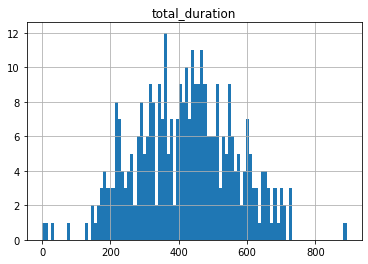

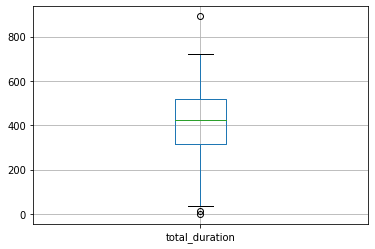

In [27]:
def describe_by_column(data, column):
    mean = data[column].mean()
    print('Среднее значение: {:.2f}'.format(mean))
    var = np.var(data[column], ddof=1)
    print('Оценка дисперсии: {:.2f}'.format(var))
    std = np.sqrt(var)
    print('Оценка стандартного отклонения: {:.2f}'.format(std))
    histogram(data, column, 100)
    boxplotfunc(data, column)
    
describe_by_column(filtered_users_data_smart, 'total_duration')

- *'total_messages'*

Среднее значение: 32.35
Оценка дисперсии: 702.91
Оценка стандартного отклонения: 26.51


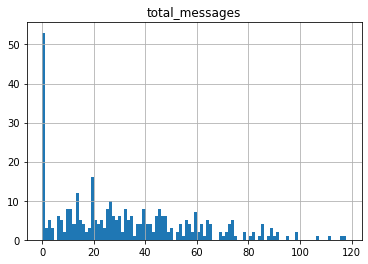

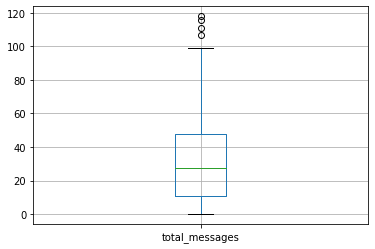

In [28]:
describe_by_column(filtered_users_data_smart, 'total_messages')

- *'total_mb_used'*

Среднее значение: 16201.39
Оценка дисперсии: 12842481.46
Оценка стандартного отклонения: 3583.64


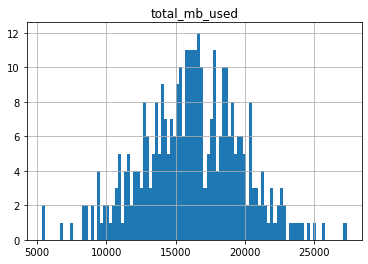

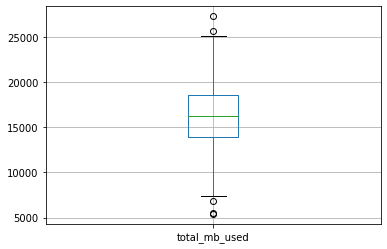

In [29]:
describe_by_column(filtered_users_data_smart, 'total_mb_used')

В среднем длительность одного телефонного звонка клиента тарифа "Smart" составляет немногим менее 9 минут. Ежемесячная потребность такого клиента составляет примерно 420 минут разговора, 33 сообщения и 16 ГБ интернет-трафика, что в целом (кроме в незначительной степени касается интернета) укладывается в отведеные лимиты тарифа.

Распределения близки к распределению Пуассона, однако на гистограмме количества сообщений имеется значительный выброс на нулевом значении. Скорее всего это вызвано тем, что услуга отправки SMS/MMS сообщений теряет свою актуальность в связи с использованием мессенджеров - их практически никто не отправляет. 

Практически все наблюдения лежат в пределах трех сигм. 

### тариф "Ultra"

In [30]:
print(filtered_users_data_ultra.loc[:, ['total_duration', 'total_messages', 'total_mb_used', 'mean_duration']].describe())

       total_duration  total_messages  total_mb_used  mean_duration
count      148.000000      148.000000     148.000000     148.000000
mean       527.821819       54.030743   19592.839001       8.561504
std        281.786359       46.366246    8318.753942       1.701247
min          0.000000        0.000000       0.000000       0.000000
25%        325.437500       17.000000   14504.429545       8.600942
50%        514.541667       45.500000   18715.550000       8.896529
75%        746.972222       84.250000   25906.544643       9.118536
max       1179.363636      192.000000   38502.000000      10.716941


- *'total_duration'*

Среднее значение: 527.82
Оценка дисперсии: 79403.55
Оценка стандартного отклонения: 281.79


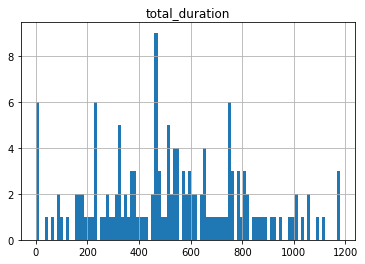

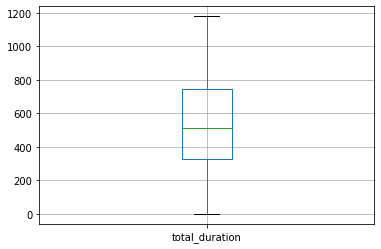

In [31]:
describe_by_column(filtered_users_data_ultra, 'total_duration')

- *'total_messages'*

Среднее значение: 54.03
Оценка дисперсии: 2149.83
Оценка стандартного отклонения: 46.37


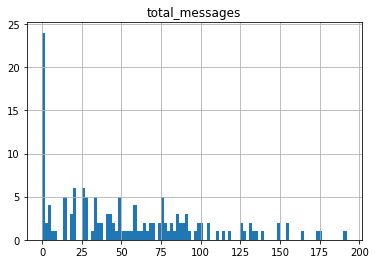

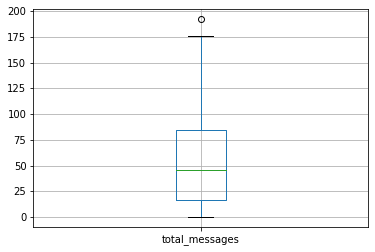

In [32]:
describe_by_column(filtered_users_data_ultra, 'total_messages')

- *'total_mb_used'*

Среднее значение: 19592.84
Оценка дисперсии: 69201667.15
Оценка стандартного отклонения: 8318.75


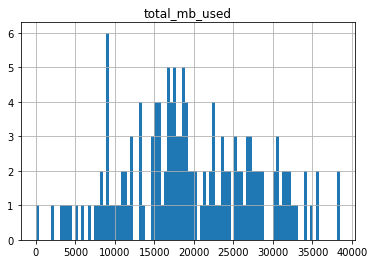

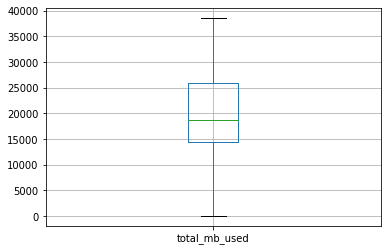

In [33]:
describe_by_column(filtered_users_data_ultra, 'total_mb_used')

В среднем длительность одного телефонного звонка клиента тарифа "Ultra" составляет чуть больше 8,5 минут. Ежемесячная потребность такого клиента составляет примерно 528 минут разговора, 54 сообщения и 19 ГБ интернет-трафика, что с лихвой укладывается в отведеные лимиты тарифа - при этом никто не превысил установленный лимит по минутам и отправленным сообщениям, оставив значительный неиспользованный запас.

Распределения, аналогично тарифу "Smart", близки к распределению Пуассона, однако на гистограмме количества сообщений имеется значительный выброс на нулевом значении. Скорее всего это вызвано тем, что услуга отправки SMS/MMS сообщений теряет свою актуальность в связи с использованием мессенджеров - их практически никто не отправляет. 

Практически все наблюдения лежат в пределах трех сигм. 

## Проверка гипотез

### Гипотеза "Средняя выручка пользователей тарифов «Ultra» и «Smart» различается"

Поскольку у нас имеются две совокупности, у которых необходимо сопоставить их средние, изпользуем метод scipy.stats.ttest_ind для проверки гипотезы о равенстве средних двух генеральных совокупностей. Параметр equal_var установим равным False, т.к. тарифы «Ultra» и «Smart» имеют разные характеристики:

Для начала сформулируем нулевую гипотезу:  
$H_0$: "Средняя выручка пользователей тарифа «Ultra» равна средней выручке пользователей тарифа «Smart»"  
Сформулируем альтернативную гипотезу:  
$H_1$: "Средняя выручка пользователей тарифов «Ultra» и «Smart» различается"  

Установим критический уровень статистической значимости равным 1%

In [34]:
alpha = 0.01

results = st.ttest_ind(filtered_users_data_smart['total_revenue'], filtered_users_data_ultra['total_revenue'], equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.090243689943366e-61
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что средняя выручка пользователей обозначенных тарифов неодинакова; вероятность того, что такое или большее различие можно получить случайно - маловероятно. 
Можно со значительной степенью уверенности сказать о том, что средняя выручка пользователей тарифов «Ultra»  и «Smart» различается.

### Гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Поскольку у нас имеются также две совокупности, у которых необходимо сопоставить их средние, изпользуем метод scipy.stats.ttest_ind для проверки гипотезы о равенстве средних двух генеральных совокупностей. Параметр equal_var установим равным True, т.к. выборки взяты по схожим параметрам:

Для начала сформулируем нулевую гипотезу:  
$H_0$: "Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов"  
Сформулируем альтернативную гипотезу:  
$H_1$: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"  

Установим критический уровень статистической значимости равным 1%

In [35]:
alpha = 0.01

results = st.ttest_ind(final_users_data.query('city == "Москва"')['total_revenue'], final_users_data.query('city != "Москва"')['total_revenue'], equal_var = True)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4348929171989182
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей Москвы равна средней выручке пользователей из других регионов, с вероятностью почти 43% такое совпадение можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о равенстве средней выручки пользователей в Москве и других регионах.

## Заключение и общие выводы по проекту

Проведенное исследование показало, что пользователи тарифа «Smart» в практически полностью используют потенциал своего тарифа - средние значения количества использованных минут, сообщений и интернет-трафика близки к предлагаемым тарифом лимитам.

В свою очередь этого нельзя сказать о пользователях тарифа «Ultra» - по итогам месяца у них зачастую остается большое количество неиспользованных минут, сообщений, и - в меньшей мере - интернет-трафика.

Проверка гипотезы о различии средней выручки пользователей обозначенных тарифов показала высокую вероятность того, что это действительно так. 

Проверка гипотезы о различии средней выручки пользователей из Москвы и пользователей из других регионов не подтвердила данный тезис, однако с высокой долей вероятности это могло оказаться лишь совпадением.